In [656]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import sklearn.metrics as sklm
import warnings
import math
from scipy import stats
from scipy.stats import norm
warnings.filterwarnings('ignore')
%matplotlib inline

In [657]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [658]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [659]:
numeric = train.select_dtypes(exclude='object')
categorical = train.select_dtypes(include='object')

In [660]:
num_corr = numeric.corr()
table = num_corr['SalePrice'].sort_values(ascending=False).to_frame()
cm = sns.light_palette("green", as_cmap=True)
tb = table.style.background_gradient(cmap=cm)
tb

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


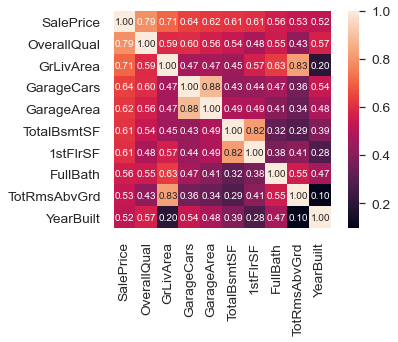

In [661]:
k = 10
cols = train.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [662]:
ntrain = train.shape[0] # число строк в train
ntest = test.shape[0]   # число строк в test
y = train['SalePrice'].to_frame()
all_data = pd.concat((train,test),sort=False).reset_index(drop = True)
all_data.drop(['SalePrice','Id'], axis = 1, inplace = True)

In [663]:
all_data = all_data.dropna(thresh = len(all_data) * 0.8, axis = 1)

all_data.shape

(2919, 74)

**Заполняем пропуски в данных**

In [664]:
# только категориальные признаки содержащие NaN
NanCat = all_data.loc[:,all_data.isna().any()].select_dtypes(include='object')

In [665]:
# заполним колонки с 1 "NaN" прямым заполнением
fill_cols = ['Electrical', 'SaleType', 'KitchenQual', 'Exterior1st',
             'Exterior2nd', 'Functional', 'Utilities', 'MSZoning']

for col in all_data[fill_cols]:
    all_data[col] = all_data[col].fillna(method='ffill')


In [666]:
#Categorical missing values
NAcols = all_data.columns
for col in NAcols:
    if all_data[col].dtype == "object":
        all_data[col] = all_data[col].fillna("None")

In [667]:
for col in NAcols:
    if all_data[col].dtype != "object":
        all_data[col]= all_data[col].fillna(0)

In [668]:
all_data.isnull().sum().sort_values(ascending=False).head()

SaleCondition    0
YearRemodAdd     0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
dtype: int64

**Преобразуем несколько признаков в более информативные признаки**

In [669]:
all_data['TotalArea'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'] + all_data['GrLivArea'] +all_data['GarageArea']
all_data['Bathrooms'] = all_data['FullBath'] + all_data['HalfBath']*0.5 
all_data['Year average']= (all_data['YearRemodAdd']+all_data['YearBuilt'])/2

**Переводим категориальные признаки**

In [670]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)

In [671]:
# сделаем колонку Есть/Нет подвал
all_data['HasBsmt'] = pd.Series(len(all_data['TotalBsmtSF']), index=all_data.index)
all_data['HasBsmt'] = 0 
all_data.loc[all_data['TotalBsmtSF']>0,'HasBsmt'] = 1

all_data = pd.get_dummies(all_data)

In [672]:
train = all_data[:ntrain]
test = all_data[ntrain:]

**Анализ выбросов**

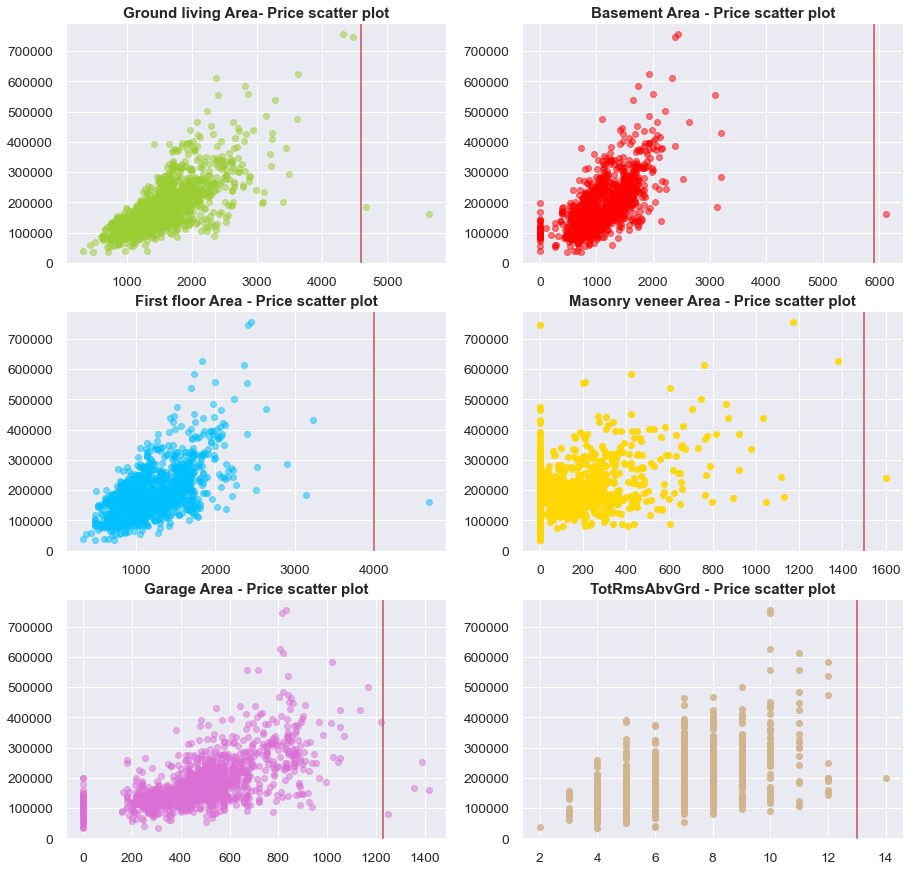

In [673]:
fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot2grid((3,2),(0,0))
plt.scatter(x = train['GrLivArea'], y = y, color=('yellowgreen'), alpha=0.5)
plt.axvline(x=4600, color='r', linestyle='-')
plt.title('Ground living Area- Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((3,2),(0,1))
plt.scatter(x = train['TotalBsmtSF'], y = y, color=('red'),alpha=0.5)
plt.axvline(x=5900, color='r', linestyle='-')
plt.title('Basement Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((3,2),(1,0))
plt.scatter(x = train['1stFlrSF'], y = y, color=('deepskyblue'),alpha=0.5)
plt.axvline(x=4000, color='r', linestyle='-')
plt.title('First floor Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((3,2),(1,1))
plt.scatter(x = train['MasVnrArea'], y = y, color=('gold'),alpha=0.9)
plt.axvline(x=1500, color='r', linestyle='-')
plt.title('Masonry veneer Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((3,2),(2,0))
plt.scatter(x = train['GarageArea'], y = y, color=('orchid'),alpha=0.5)
plt.axvline(x=1230, color='r', linestyle='-')
plt.title('Garage Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((3,2),(2,1))
plt.scatter(x = train['TotRmsAbvGrd'], y = y, color=('tan'),alpha=0.9)
plt.axvline(x=13, color='r', linestyle='-')
plt.title('TotRmsAbvGrd - Price scatter plot', fontsize=15, weight='bold' )
plt.show()

**Посмотрим на эти выбросы**

In [674]:
train['GrLivArea'].sort_values(ascending=False).head(2)

1298    5642
523     4676
Name: GrLivArea, dtype: int64

In [675]:
train['TotalBsmtSF'].sort_values(ascending=False).head(1)

1298    6110.0
Name: TotalBsmtSF, dtype: float64

In [676]:
train['MasVnrArea'].sort_values(ascending=False).head(1)

297    1600.0
Name: MasVnrArea, dtype: float64

In [677]:
train['1stFlrSF'].sort_values(ascending=False).head(1)

1298    4692
Name: 1stFlrSF, dtype: int64

In [678]:
train['GarageArea'].sort_values(ascending=False).head(4)

1298    1418.0
581     1390.0
1190    1356.0
1061    1248.0
Name: GarageArea, dtype: float64

In [679]:
train['TotRmsAbvGrd'].sort_values(ascending=False).head(1)

635    14
Name: TotRmsAbvGrd, dtype: int64

In [680]:
train = train[(train['GrLivArea'] < 4600) & (train['MasVnrArea'] < 1500)]

pos = [1298,523, 297]
y.drop(y.index[pos], inplace=True)

**Логарифмическое преобразование перекошенных числовых объектов**

In [681]:
print("Skewness before log transform: ", train['GrLivArea'].skew())
print("Kurtosis before log transform: ", train['GrLivArea'].kurt())

Skewness before log transform:  1.0127645385480262
Kurtosis before log transform:  2.0672339304153655


In [682]:
print("Skewness before log transform: ", y['SalePrice'].skew())
print("Kurtosis before log transform: ",y['SalePrice'].kurt())

Skewness before log transform:  1.8829247000823222
Kurtosis before log transform:  6.527120338179705


In [683]:
y["SalePrice"] = np.log1p(y["SalePrice"])

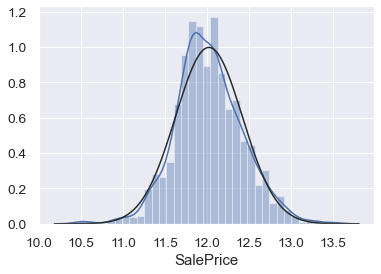

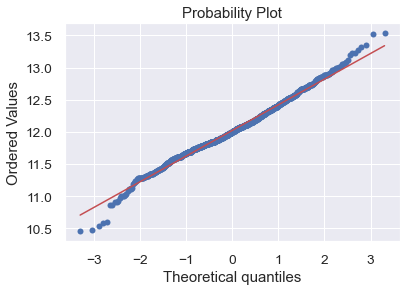

In [684]:
#transformed histogram and normal probability plot
sns.distplot(y["SalePrice"], fit=norm);
fig = plt.figure()
res = stats.probplot(y["SalePrice"], plot=plt)

In [685]:
print("Skewness after log transform: ", y['SalePrice'].skew())
print("Kurtosis after log transform: ",y['SalePrice'].kurt())

Skewness after log transform:  0.12299462625722304
Kurtosis after log transform:  0.8062416349541666


**Разделяем выборку**

In [686]:
from sklearn.model_selection import train_test_split
'''X = train.drop(['SalePrice'],axis='columns')'''
X = train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)

**Стандартизируем данные**

In [687]:
from sklearn.preprocessing import RobustScaler
ss = RobustScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

predict_data_scaled = ss.transform(test)

**Строим модель случайных лесов для отбора признаков**

In [689]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)

feat_labels = all_data.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Важности признаков')
plt.bar(range(X_train_scaled.shape[1]), importances[indices], color = 'lightblue', align = 'center')
plt.xticks(range(X_train_scaled.shape[1]), feat_labels[indices], rotation = 90)
plt.xlim([-1,X_train_scaled.shape[1]])
plt.tight_layout()
plt.show()


ValueError: Unknown label type: 'continuous'

In [ ]:
indices

In [ ]:
from sklearn.linear_model import ElasticNetCV


alphas = [10,1,0.1,0.01,0.001,0.002,0.003,0.004,0.005,0.00054255]
l1ratio = [0.1, 0.3,0.5, 0.9, 0.95, 0.99, 1]
 
regr = ElasticNetCV(cv = 5,alphas = alphas , l1_ratio = l1ratio , max_iter = 1000)
regr.fit(X_train_scaled,y_train)
'''regr.score(X_test_scaled,y_test)'''


pred = regr.predict(X_test_scaled)
print('Root Mean Square Error test = ' + str(math.sqrt(sklm.mean_squared_error(y_test, pred))))

In [ ]:
predicts = regr.predict(predict_data_scaled)
predicts = np.expm1(predicts)
df = pd.DataFrame()
df['Id'] = range(1461,2920)
df['SalePrice'] = predicts
df.to_csv('predictions.csv',index = False)